The purpose of this notebook is to evaluate GPDs $G_q(x,\eta,t)$ as well as their conformal moments $\mathbb{G}_q(n,\eta,t)$, where, for a generic GPD, we have its conformal moment expansion
\begin{equation}
G_q(x,\eta,t)=\sum_{n=0}^\infty (-1)^{n}p_n(x,\eta)\mathbb{F}_q(n,\eta,t),\qquad G_g(x,\eta,t)=\sum_{n=1}^\infty (-1)^{n-1}\, {^g\!p}_n(x,\eta) \mathbb{G}_g(n,\eta,t),
\end{equation}
where $G=H,E,\widetilde{H},\widetilde{E},H^T,E^T,\widetilde{H}^T,\widetilde{E}^T$.

To this end, we import the MSTW PDF parametrization of PDFs. The conformal moments are obtained by Reggeized $x$ integrals over PDFs at some input scale $\mu_0=1$ GeV and evolved using the pertinent RGEs.

In [1]:
# Import necessary libraries and set display options
import time

from GPD_functions import *

# Set display options
np.set_printoptions(linewidth=200)

Plots of conformal moments $\mathbb{G}_q(n,\eta,t)$ and their RGE evolution

Momentum space

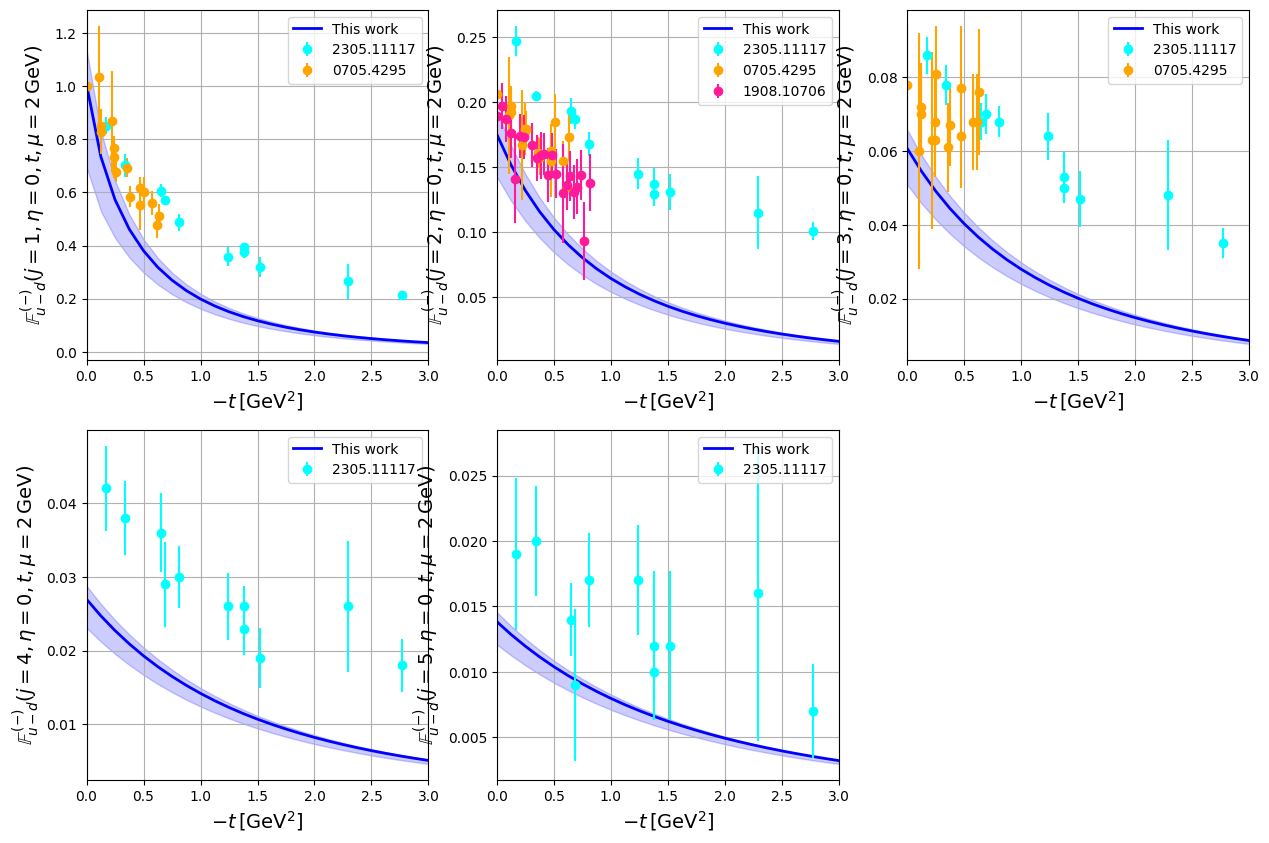

In [3]:
#NonSingletIsovector
y_label = "$\\mathbb{{F}}_{{u-d}}^{{\,\,(-)}}$"
moment_type = "NonSingletIsovector"
moment_label = "A"

plot_moments(0,y_label,3,"quark",moment_type, moment_label,25)

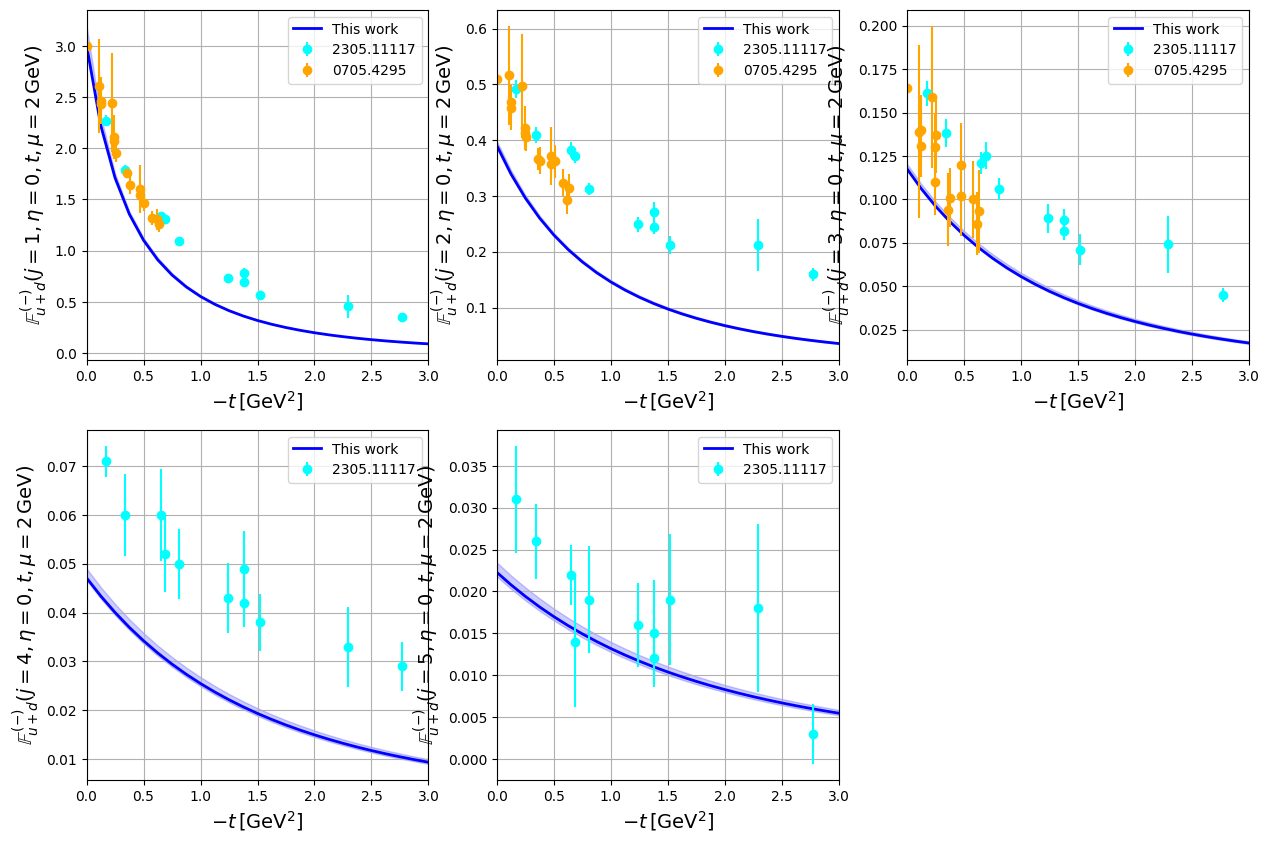

In [3]:
# NonSingletIsoscalar
y_label = "$\\mathbb{{F}}_{{u+d}}^{{\,\,(-)}}$"
moment_type = "NonSingletIsoscalar"
moment_label = "A"

plot_moments(0,y_label,3,"quark",moment_type, moment_label,25)

Impact parameter representation

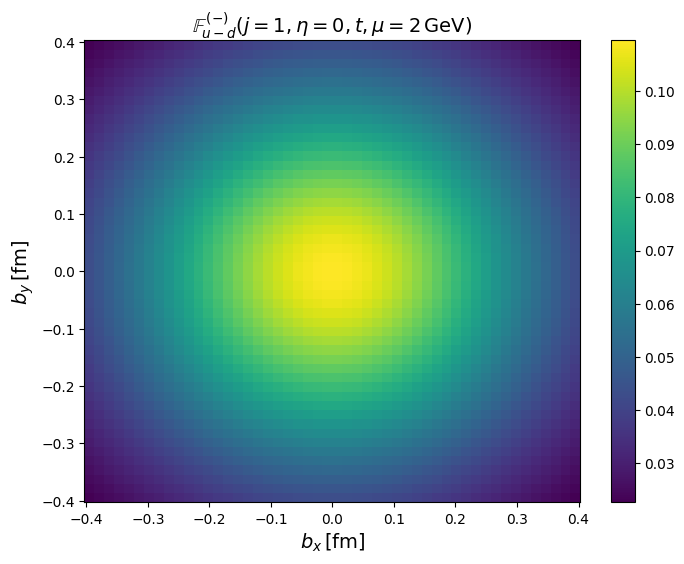

In [4]:
# Plot NonSingletIsovector in 2D impact parameter space
moment_type = "NonSingletIsovector"
moment_label = "A"
plot_title = "$\\mathbb{{F}}_{{u-d}}^{{\,\,(-)}}$"
plot_fourier_transform_moments(moment_type,moment_label,plot_title, 1, 2)

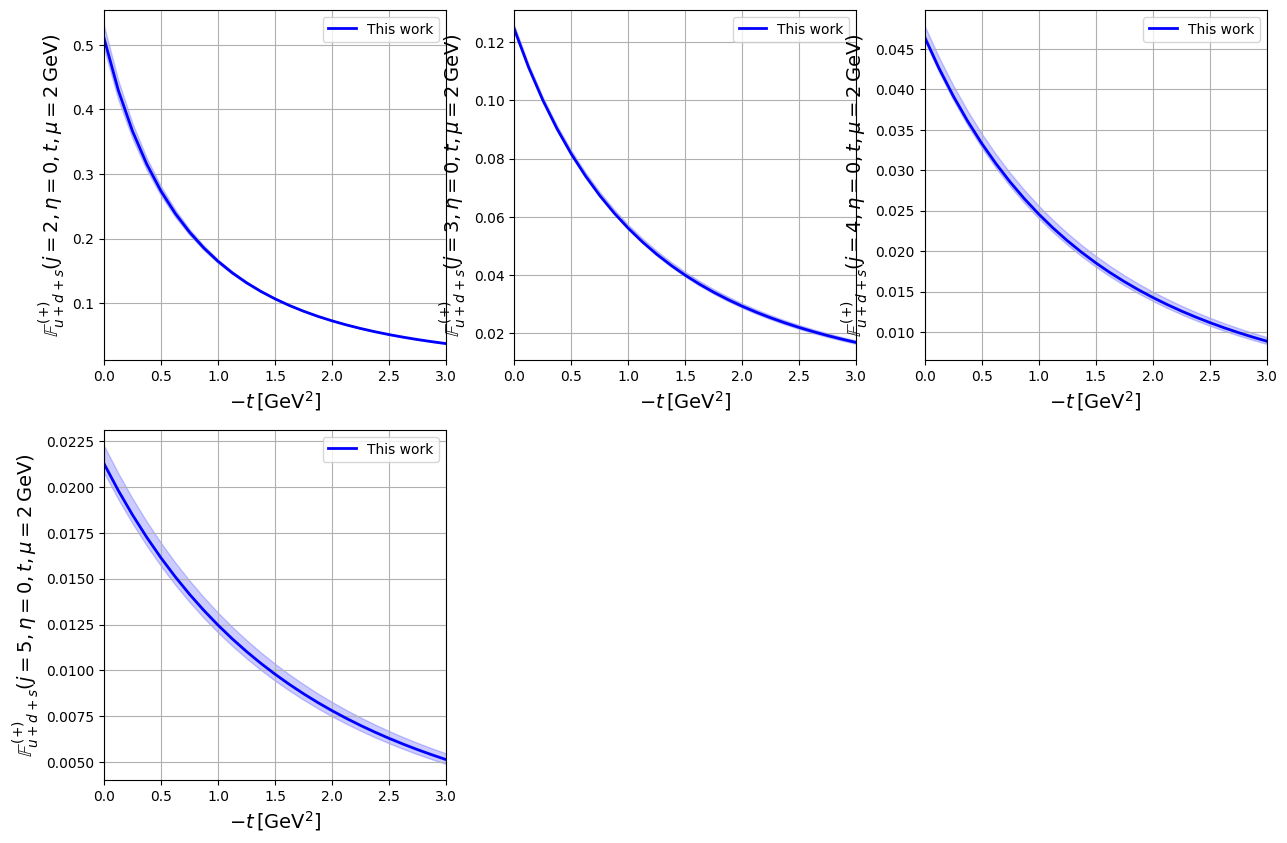

In [4]:
# Sea Quark Singlet
y_label = "$\\mathbb{{F}}_{{u+d+s}}^{{\,\,(+)}}$"
moment_type = "Singlet"
moment_label = "A"

plot_moments(0,y_label,3,"quark",moment_type, moment_label,25)

In [4]:
# 0.510024649589122
# -1.30044714988575
# 0.50111263175031
# -2.57000756593034
print(evolve_conformal_moment(2,0,-1e-4,2,3,"quark","Singlet","A","central"))
print(evolve_singlet_D(2,1,-1e-4,2,3,"quark","A","central"))
print(evolve_conformal_moment(2,0,-1e-4,2,3,"gluon","Singlet","A","central"))
print(evolve_singlet_D(2,1,-1e-4,2,3,"gluon","A","central"))

0.5100080912825354
-1.3000426341191
0.5010095423139207
-2.5700257125908


In [3]:
# Compute results for the evolution functions
def compute_results(j,eta,t_values,mu,Nf = 3,particle="quark",moment_type="NonSingletIsovector",moment_label ="A"):
    """Compute central, plus, and minus results for a given evolution function."""
    results = [float(evolve_conformal_moment(j,eta,t,mu,Nf,particle,moment_type,moment_label,"central")) for t in t_values]
    results_plus = [float(evolve_conformal_moment(j,eta,t,mu,Nf,particle,moment_type,moment_label, "plus")) for t in t_values]
    results_minus = [float(evolve_conformal_moment(j,eta,t,mu,Nf,particle,moment_type,moment_label, "minus")) for t in t_values]
    return results, results_plus, results_minus

def compute_results_D(j,eta,t_values,mu,Nf = 3,particle="quark",moment_label ="A"):
    """Compute central, plus, and minus results for a given evolution function."""
    results = [float(evolve_singlet_D(j,eta,t,mu,Nf,particle,moment_label,"central")) for t in t_values]
    results_plus = [float(evolve_singlet_D(j,eta,t,mu,Nf,particle,moment_label, "plus")) for t in t_values]
    results_minus = [float(evolve_singlet_D(j,eta,t,mu,Nf,particle,moment_label, "minus")) for t in t_values]
    return results, results_plus, results_minus

# Plot results on a provided axis or create a new plot if ax is None
def plot_results(t_values, results, results_plus, results_minus, xlabel, ylabel, ax=None):
    """Plot results on the given axis, or create a new figure if ax is None."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(-t_values, results, label="This work", color="blue")
    ax.fill_between(-t_values, results_minus, results_plus, color="blue", alpha=0.2)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.grid(True)
    ax.legend()
    if ax is None:
        plt.tight_layout()
        plt.show()

# Individual evolution plot functions with optional ax input
def plot_evolve_gluon(t_values, mu, Nf=3, ax=None):
    """Compute and plot gluon evolution."""
    results, results_plus, results_minus = compute_results(2, 0, t_values, mu, Nf, "gluon","Singlet","A")
    plot_results(t_values, results, results_plus, results_minus,
                 xlabel="$-t\,[\mathrm{GeV}^2]$", ylabel="$A_g(t,\mu = 2\,[\mathrm{GeV}])$", ax=ax)

def plot_evolve_quark_singlet(t_values, mu, Nf=3, ax=None):
    """Compute and plot quark singlet evolution."""
    results, results_plus, results_minus = compute_results(2, 0, t_values, mu, Nf, "quark","Singlet","A")
    plot_results(t_values, results, results_plus, results_minus,
                 xlabel="$-t\,[\mathrm{GeV}^2]$", ylabel="$A_{u+d+s}(t,\mu = 2\,[\mathrm{GeV}])$", ax=ax)

def plot_evolve_gluon_D(t_values, mu, Nf=3, ax=None):
    """Compute and plot gluon D evolution."""
    results, results_plus, results_minus = compute_results_D(2, 0, t_values, mu, Nf, "gluon","A")
    plot_results(t_values, results, results_plus, results_minus,
                 xlabel="$-t\,[\mathrm{GeV}^2]$", ylabel="$D_g(t,\mu = 2\,[\mathrm{GeV}])$", ax=ax)

def plot_evolve_quark_singlet_D(t_values, mu, Nf=3, ax=None):
    """Compute and plot quark singlet D evolution."""
    results, results_plus, results_minus = compute_results_D(2, 0, t_values, mu, Nf, "quark","A")
    plot_results(t_values, results, results_plus, results_minus,
                 xlabel="$-t\,[\mathrm{GeV}^2]$", ylabel="$D_{u+d+s}(t,\mu = 2\,[\mathrm{GeV}])$", ax=ax)

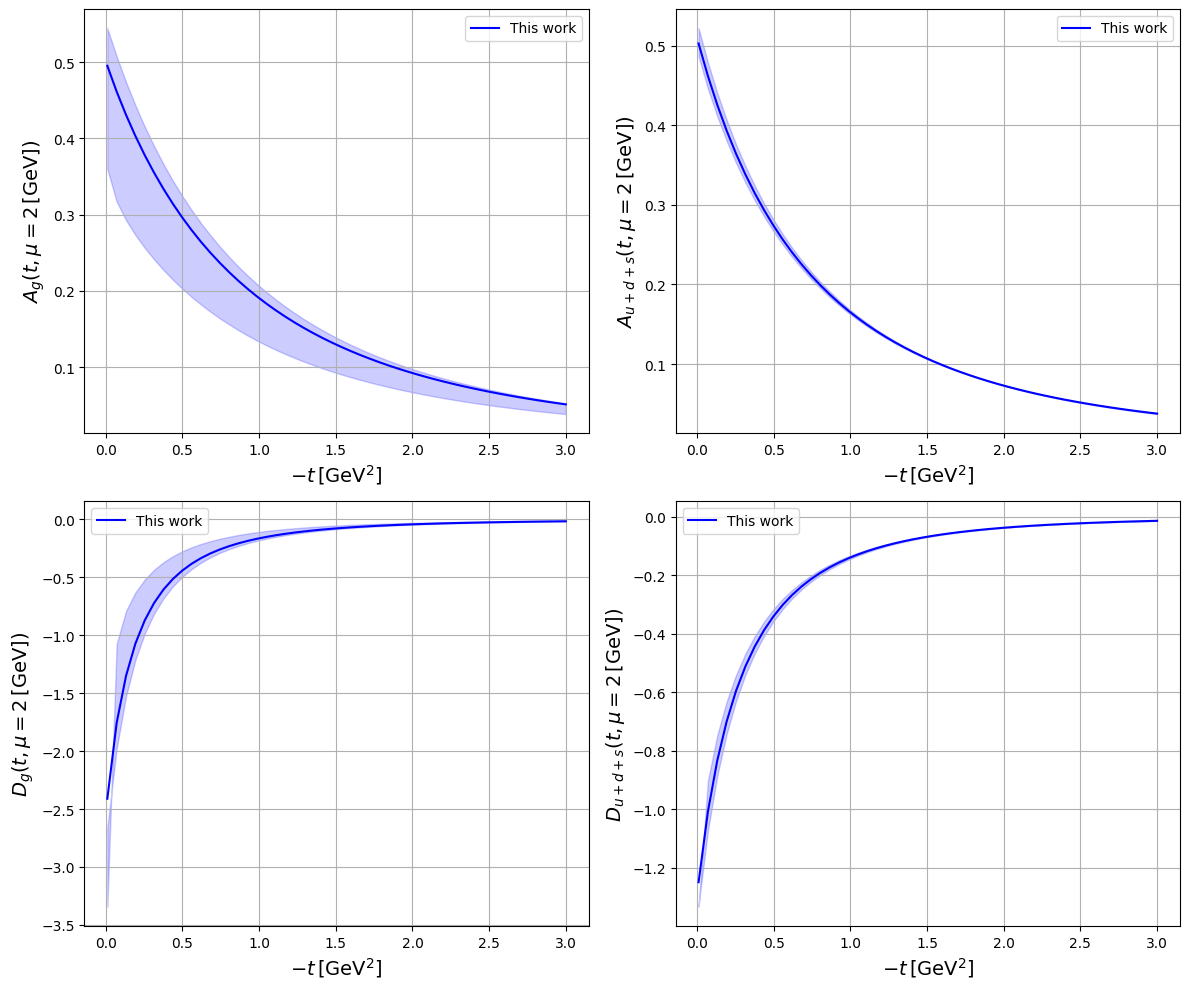

In [5]:
t_values = np.linspace(-1e-2, -3, 50)  # Generate values of t
Nf = 3  # Set Nf dynamically
mu = 2

# Parallelize data computation with Nf passed as an argument
results = Parallel(n_jobs=-1)(
    delayed(func)(t_values, mu=mu, Nf=Nf) for func in [
        plot_evolve_gluon, 
        plot_evolve_quark_singlet,
        plot_evolve_gluon_D, 
        plot_evolve_quark_singlet_D
    ]
)

# Create a figure with a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2 rows, 2 columns

# Plot results for each function on subplots
plot_evolve_gluon(t_values,mu=mu, Nf=Nf, ax=axes[0, 0])
plot_evolve_quark_singlet(t_values,mu=mu, Nf=Nf, ax=axes[0, 1])
plot_evolve_gluon_D(t_values, mu=mu , Nf=Nf, ax=axes[1, 0])
plot_evolve_quark_singlet_D(t_values, mu =mu, Nf=Nf, ax=axes[1, 1])

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

Define the conformal partial waves

In [5]:
# Define conformal partial waves
def conformal_partial_wave(j, x, eta, particle = "quark", parity="none"):
    """
    Calculate the conformal partial waves for quark and gluon GPDs and generate their
    respective "even" or "odd" combinations.

    Parameters:
    j (complex): Conformal spin
    x (float): Value of parton x
    eta (float): Value of skewness
    particle (str, optional): The particle species 'quark' or 'gluon' default is 'quark'.
    parity (str, optional): The parity of the function. Either 'even', 'odd' or 'none'. Default is 'none'.

    Returns:
    mpc: Value of even or odd combination of conformal quark partial waves

    Raises:
    ValueError: If the `parity` argument is not "even", "odd" or "none".

    Notes:
    - The result is vectorized later on using np.vectorize for handling array inputs.
    """
    if particle not in ["quark", "gluon"]:
        raise ValueError("Particle must be either quark or gluon")

    if parity not in ["even", "odd","none"]:
        raise ValueError("Parity must be even, odd or none")
    
    # Precompute factors that do not change
    if particle == "quark":
        gamma_term = lambda j: 2.0**j * gamma(1.5 + j) / (gamma(0.5) * gamma(j))
        sin_term = lambda j: mp.sin(np.pi * j) / np.pi
        eta_prf = 1 / eta**j 
        def cal_P(x):
            arg = (1 + x / eta)
            hyp = mp.hyp2f1(-j, j + 1, 2, 0.5 * arg)
            result = eta_prf * arg * hyp * gamma_term(j)
            return result
        def cal_Q(x): 
            hyp = mp.hyp2f1(0.5 * j, 0.5 * (j + 1), 1.5 + j, (eta / x)**2) 
            result = 1 / x**j * hyp * sin_term(j)
            return result
    else:   
        gamma_term = lambda j: 2.0**(j-1) * gamma(1.5 + j) / (gamma(0.5) * gamma(j-1))
        sin_term =lambda j: mp.sin(np.pi * (j+1))  / np.pi 
        eta_prf = 1 / eta**(j-1)
        def cal_P(x):
            arg = (1. + x / eta)
            hyp = mp.hyp2f1(-j, j + 1, 3, 0.5 * arg)
            result = eta_prf * arg**2 * hyp * gamma_term(j)
            return result
        def cal_Q(x): 
            hyp = mp.hyp2f1(0.5 * (j-1), 0.5 * j, 1.5 + j, (eta / x)**2) 
            result = 1 / x**(j-1) * hyp * sin_term(j)
            return result

    def p_j(x):
        # Initialize P_term and Q_term with zero
        P_term = 0
        Q_term = 0        
        if eta - np.abs(x) >= 0 :  # If condition for cal_P is satisfied
            # Note continuity at x = eta gives cal_P = cal_Q
            P_term =  cal_P(x)
        elif x - eta > 0 :
            Q_term = cal_Q(x)
        return P_term + Q_term
    
    if parity == "even":    # Even parity
        result = p_j(x) + p_j(-x)
    elif parity == "odd":   # Odd parity
        result = p_j(x) - p_j(-x)
    else :
        result = p_j(x)     # No parity for non_singlet

    #result = complex(result.real, result.imag)
    return result

In [22]:
def plot_conformal_partial_wave(j,eta,particle,parity):
    x_values = np.linspace(-1, 1, 200)
    y_values = Parallel(n_jobs=-1)(delayed(conformal_partial_wave)(j, x, eta , particle, parity) for x in x_values)

    # Separate real and imaginary parts
    y_values_real = [float(y.real) for y in y_values]
    y_values_imag = [float(y.imag) for y in y_values]

    # Create subplots for real and imaginary parts
    plt.figure(figsize=(10, 6))  # Adjust figure size for better visualization

    #plt.subplot(2, 1, 1)
    plt.plot(x_values, y_values_real)
    plt.xlabel("x")
    plt.ylabel("Real Part")
    plt.title(f"Real Part of Conformal Partial Wave for {particle} with Parity {parity}")

    #plt.subplot(2, 1, 2)
    plt.plot(x_values, y_values_imag)
    plt.xlabel("x")
    plt.ylabel("Imaginary Part")
    plt.title(f"Imaginary Part of Conformal Partial Wave for {particle} with Parity {parity}")

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

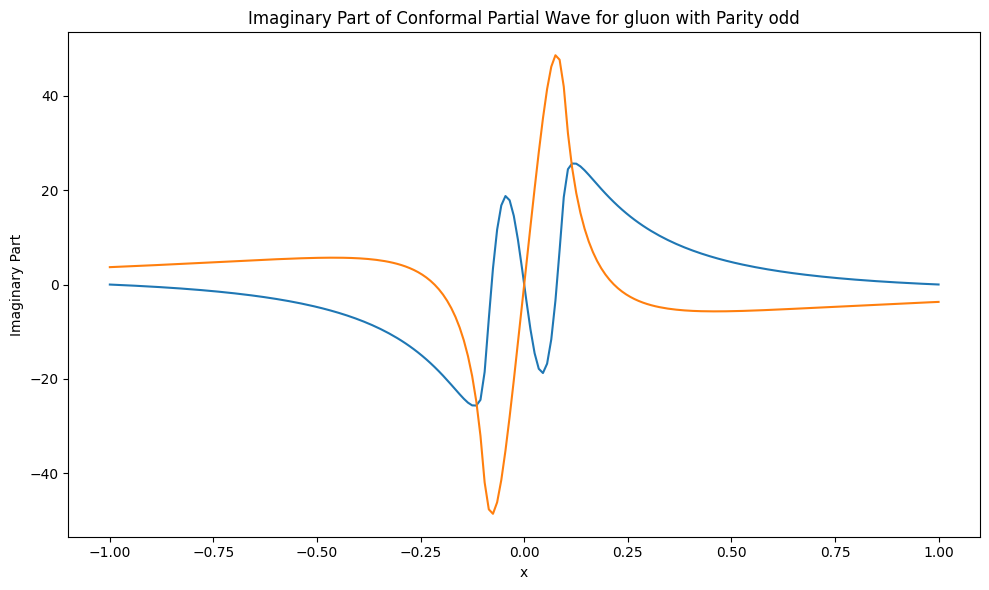

In [23]:
plot_conformal_partial_wave(2+1j,.1,"gluon","odd")

In [7]:
# Define get_j_base which contains real part of integration variable
def get_j_base(particle="quark",parity="none"):
    if particle == "quark":
        if parity == "even":
            print(f"j_base_q of parity {parity} is tbd")
            j_base = 1.1
        elif parity == "odd":
            j_base = 2.7
        elif parity == "none":
            j_base = .95
        else :
            raise ValueError("Parity must be even, odd or none")
        return j_base 
    elif particle == "gluon":
        if parity == "even":
            j_base = 3
        elif parity == "odd":
            print(f"j_base_g of parity {parity} is tbd")
            j_base = 2
        elif parity == "none":
            print(f"j_base_g of parity {parity} is tbd")
            j_base = 2
        else :
            raise ValueError("Parity must be even, odd or none")
        return j_base
    else:
        raise ValueError("Particle must be quark or gluon")

Mellin-Barnes Integral

In [4]:
def plot_integrand(x, eta, t, mu, Nf=3, particle="quark", moment_type="Singlet", moment_label="A", error_type="central", j_max=7.5):
    """
    Plot the real and imaginary parts of the integrand over k.

    Parameters:
    - x, eta, t, mu: Physical parameters.
    - Nf (int): Number of flavors.
    - particle (str): Particle species ("quark" or "gluon").
    - moment_type (str): Moment type ("Singlet", "NonSingletIsovector", "NonSingletIsoscalar").
    - moment_label (str): Moment label ("A", "A_tilde", "B").
    - error_type (str): PDF value type ("central", "plus", "minus").
    - j_max (float): Maximum value of k for plotting.
    """
    if moment_type == "Singlet":
        if particle == "quark":
            parity = "odd"
        elif particle == "gluon":
            parity = "even"
        else:
            raise ValueError("Particle must be 'quark' or 'gluon'")
    elif moment_type == "NonSingletIsovector":
        parity = "none"
    elif moment_type == "NonSingletIsoscalar":
        parity = "none"

    j_base = get_j_base(particle, parity)

    if eta == 0:
        eta = 1e-6

    def integrand_real(k):
        z = j_base + 1j * k
        dz = 1j
        sin_term = mp.sin(np.pi * z)
        pw_val = conformal_partial_wave(z, x, eta, particle, parity)
        if particle == "quark":
            if moment_type == "Singlet":
                mom_val = evolve_quark_singlet(z, eta, t, mu, Nf, moment_label, error_type)
            else:
                mom_val = evolve_quark_non_singlet(z, eta, t, mu, Nf, moment_type, moment_label, error_type)
        else:
            mom_val = evolve_gluon_singlet(z, eta, t, mu, Nf=Nf, error_type=error_type)
        result = -0.5j * dz * pw_val * mom_val / sin_term
        return result.real

    def integrand_imag(k):
        z = j_base + 1j * k
        dz = 1j
        sin_term = mp.sin(np.pi * z)
        pw_val = conformal_partial_wave(z, x, eta, particle, parity)
        if particle == "quark":
            if moment_type == "Singlet":
                mom_val = evolve_quark_singlet(z, eta, t, mu, Nf, moment_label, error_type)
            else:
                mom_val = evolve_quark_non_singlet(z, eta, t, mu, Nf, moment_type, moment_label, error_type)
        else:
            mom_val = (-1) * evolve_gluon_singlet(z, eta, t, mu, Nf=Nf, error_type=error_type)
        result = -0.5j * dz * pw_val * mom_val / sin_term
        return result.imag

    print(f"Integrand at j_max={j_max}")
    print(integrand_real(j_max))
    print(integrand_imag(j_max))

    # Define k range for plotting
    k_values = np.linspace(-j_max, j_max, 300)
    # Parallel computation of real and imaginary parts
    real_values = Parallel(n_jobs=-1)(delayed(integrand_real)(k) for k in k_values)
    imag_values = Parallel(n_jobs=-1)(delayed(integrand_imag)(k) for k in k_values)

    # Plotting
    fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    ax[0].plot(k_values, real_values, label="Real Part", color="blue")
    ax[0].set_ylabel("Real Part")
    ax[0].legend()
    ax[0].grid()

    ax[1].plot(k_values, imag_values, label="Imaginary Part", color="red")
    ax[1].set_xlabel("k")
    ax[1].set_ylabel("Imaginary Part")
    ax[1].legend()
    ax[1].grid()

    plt.suptitle("Integrand Real and Imaginary Parts")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_integrand_real(x, eta, t, mu, Nf=3, particle="quark", moment_type="Singlet", moment_label="A", error_type="central", j_min = -1, j_max=7.5):
    """
    Plot the real part of the integrand over k.

    Parameters:
    - x, eta, t, mu: Physical parameters.
    - Nf (int): Number of flavors.
    - particle (str): Particle species ("quark" or "gluon").
    - moment_type (str): Moment type ("Singlet", "NonSingletIsovector", "NonSingletIsoscalar").
    - moment_label (str): Moment label ("A", "A_tilde", "B").
    - error_type (str): PDF value type ("central", "plus", "minus").
    - j_max (float): Maximum value of k for plotting.
    """
    if moment_type == "Singlet":
        if particle == "quark":
            parity = "odd"
        elif particle == "gluon":
            parity = "even"
        else:
            raise ValueError("Particle must be 'quark' or 'gluon'")
    elif moment_type == "NonSingletIsovector":
        parity = "none"
    elif moment_type == "NonSingletIsoscalar":
        parity = "none"

    if eta == 0:
        eta = 1e-6

    def integrand_real(k):
        z = k
        dz = 1
        sin_term = mp.sin(np.pi * z) 
        pw_val = conformal_partial_wave(z, x, eta, particle, parity) 

        if particle == "quark":
            if moment_type == "Singlet":
                mom_val = evolve_quark_singlet(z, eta, t, mu, Nf, moment_label, error_type)
            else:
                mom_val = evolve_quark_non_singlet(z, eta, t, mu, Nf, moment_type, moment_label, error_type)
        else:
            mom_val = evolve_gluon_singlet(z, eta, t, mu, Nf=Nf, error_type=error_type)

        result = dz * pw_val * mom_val / sin_term
        return result.real

    # Define k range for plotting
    k_values = np.linspace(j_min, j_max, 300)

    # Parallel computation of real parts
    real_values = Parallel(n_jobs=-1)(delayed(integrand_real)(k) for k in k_values)

    # Plotting
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    ax.plot(k_values, real_values, label="Real Part", color="blue")
    ax.set_ylabel("Real Part")
    ax.legend()
    ax.grid()

    plt.suptitle("Integrand Real Part")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


Integrand at j_max=100
0.000376615540508499
8.7176718823336e-5


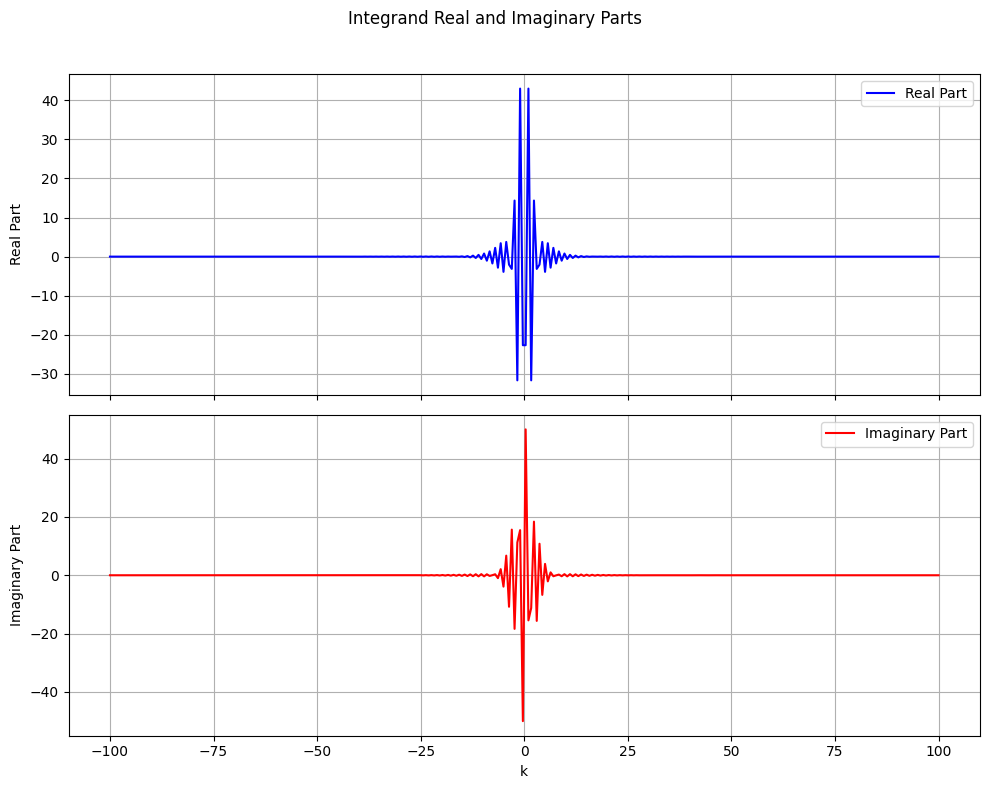

In [29]:
plot_integrand(x=1e-2, eta=1e-4, t=-0.1, mu=1.0, j_max=100,particle="gluon",moment_type="Singlet")

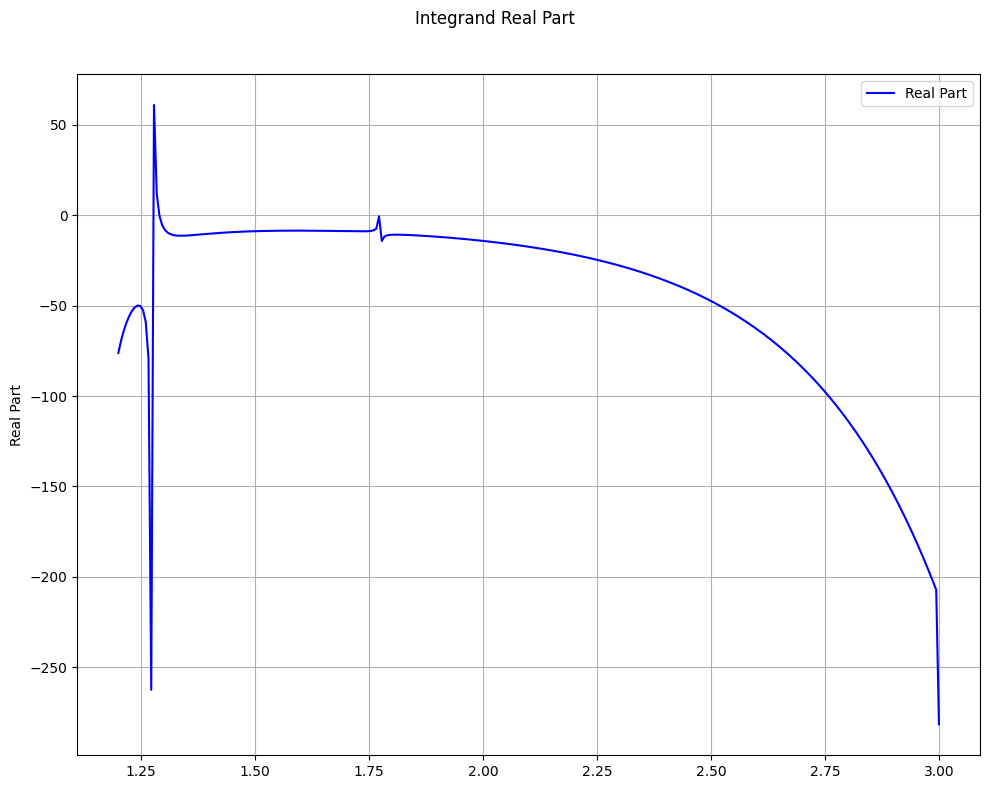

In [47]:
plot_integrand_real(x=1e-2, eta=1e-4, t=-0.1, mu=2.0,j_min =1.2, j_max=3,particle="gluon",moment_type="Singlet")

In [8]:
def mellin_barnes(x, eta, t, mu, Nf=3, particle = "quark", moment_type="Singlet",moment_label="A", error_type="central",real_imag ="real",j_max = 15, n_jobs=-1):
    """
    Numerically evaluate the Mellin-Barnes integral parallel to the imaginary axis
    
    Parameters:
    - x (float): Parton x
    - eta (float): Skewness.
    - t (float): Mandelstam t
    - mu (float): Resolution scale
    - Nf (int 1<= Nf <=3 ): Number of flavors
    - particle (str): particle species (quark or gluon)
    - moment_type (str): Singlet, NonSingletIsovector, NonSingletIsoscalar
    - moment_label (str): A, A_tilde, B
    - error_type (str): value of input PDFs (central, plus, minus)
    - real_imag (str): Choose to compute real part, imaginary part or both
    - j_max (float): Integration range parallel to the imaginary axis
    - n_jobs (int): Number of subregions, and thus processes, the integral is split into
    - n_k (int): Number of sampling points within the interval [-j_max,j_max]
    
    Returns: 
    - The value of the Mellin barnes integral with real and imaginary part.
    Note:
    - For low x and/or eta it is recommended to divide the integration region
    """
    if particle not in ["quark", "gluon"]:
        raise ValueError("Particle must be either quark or gluon")
    if moment_type not in ["Singlet","NonSingletIsovector","NonSingletIsoscalar"]:
        raise ValueError("moment_type must be Singlet, NonSingletIsovector or NonSingletIsoscalar")
    
    if moment_type == "Singlet":
        if particle == "quark":
            # Scale fixed by it's value at the input scale:
            # print(mellin_barnes_singlet_q(7.5,1e-3,0,-1e-3,1))
            # print(uv_PDF(1e-3)+dv_PDF(1e-3)+Sv_PDF(1e-3)) 
            norm = 1.78160932e+03/ 1.61636674e+03
            parity = "odd"
        elif particle == "gluon":
            # Fix to gluon PDF at input scale:
            # print(mellin_barnes_gluon(.1,0,-1e-4,1))
            # print(.1 gluon_PDF(.1))
            norm = 0.86852857/9.93131764e-01
            parity = "even"
    elif moment_type == "NonSingletIsovector":
        # Scale fixed by it's value at the input scale:
        # print(uv_minus_dv_PDF(1e-4))
        # print(mellin_barnes(1e-4,0,-1e-7,1,moment_type="NonSingletIsovector",moment_label="A"))
        norm = 152.92491544/153.88744991730528
        parity = "none"
    elif moment_type == "NonSingletIsoscalar":
        # To Do
        print("NonSingletIsoscalar norm is To Do")
        norm = 1
        parity = "none"
    
    j_base = get_j_base(particle,parity)

    if eta == 0: # Avoid division by zero in the Q partial wave
        eta = 1e-6
    # Integrand function which returns both real and imaginary parts
    def integrand(k, real_imag):
        """
        Calculates the integrand for the given k value and returns either 
        the real, imaginary part, or both.

        Args:
            k: The independent variable for integration.
            real_imag: A string specifying whether to return 'real', 'imag', or 'both'.

        Returns:
            If real_imag is 'real':
                The real part of the integrand.
            If real_imag is 'imag':
                The imaginary part of the integrand.
            If real_imag is 'both':
                A tuple containing the real and imaginary parts of the integrand.
        """
        z = j_base + 1j * k 
        dz = 1j
        sin_term = mp.sin(np.pi * z)
        pw_val = conformal_partial_wave(z, x, eta, particle, parity)

        if particle == "quark":
            if moment_type == "Singlet":
                mom_val = evolve_quark_singlet(z,eta,t,mu,Nf,moment_label,error_type)
            else:
                mom_val = evolve_quark_non_singlet(z,eta,t,mu,Nf,moment_type,moment_label,error_type)
        else:
            # (-1) from shift in Sommerfeld-Watson transform
            mom_val = (-1) * evolve_gluon_singlet(z,eta,t,mu,Nf, moment_label,error_type)
        result = -.5j * dz * pw_val * mom_val / sin_term

        if real_imag == 'real':
            return result.real
        elif real_imag == 'imag':
            return result.imag
        elif real_imag == 'both':
            return result.real, result.imag
        else:
            raise ValueError("real_imag must be either 'real', 'imag', or 'both'")

    def find_integration_bound(integrand, j_max, tolerance=1e-2, step_size=10, max_iterations=50):
        """
        Finds an appropriate upper integration bound for an oscillating integrand.

        Args:
            integrand: The function to be integrated.
            tolerance: The desired tolerance for the integrand's absolute value.
            step_size: The increment to increase the integration bound in each step.
            max_iterations: The maximum number of iterations to perform.

        Returns:
            The determined upper integration bound.

        Raises:
            ValueError: If the maximum number of iterations is reached without finding a suitable bound.
        """
        iterations = 0

        while abs(integrand(j_max, "real")) > tolerance and iterations < max_iterations:
            j_max += step_size
            iterations += 1

        if iterations == max_iterations:
            raise ValueError("Maximum number of iterations reached without finding a suitable bound. Increase initial value of j_max")

        # Check for rapid oscillations
        if abs(integrand(j_max,  "real") - integrand(j_max + 2,  "real")) > tolerance:
            while abs(integrand(j_max,  "real")) > tolerance and iterations < max_iterations:
                j_max += step_size
                iterations += 1

            if iterations == max_iterations:
                raise ValueError("Maximum number of iterations reached without finding a suitable bound. Increase initial value of j_max")
        #print(iterations,integrand(j_max,real_imag))
        return j_max

    # Function to integrate over a subinterval of k 
    def integrate_subinterval(k_values, real_imag):
        """
        Integrates the integrand over the specified subinterval and 
        returns either the real, imaginary part, or both.

        Args:
            k_values: A list or array containing the minimum and maximum k values.
            real_imag: A string specifying whether to return 'real', 'imag', or 'both'.

        Returns:
            If real_imag is 'real':
                A tuple containing the real part of the integral and its error.
            If real_imag is 'imag':
                A tuple containing the imaginary part of the integral and its error.
            If real_imag is 'both':
                A tuple containing the real part, its error, the imaginary part, 
                and its error.
        """
        k_min = k_values[0]
        k_max = k_values[-1]

        if real_imag == 'real':
            integral, error = quad(lambda k: integrand(k, 'real'), k_min, k_max, limit = 200)
            # Use symmetry of the real part of the integrand
            integral *= 2
            error *= 2
            return integral, error
        elif real_imag == 'imag':
            integral, error = quad(lambda k: integrand(k, 'imag'), k_min, k_max, limit = 200)
            return integral, error
        elif real_imag == 'both':
            real_integral, real_error = quad(lambda k: integrand(k, 'real'), k_min, k_max, limit = 200)
            imag_integral, imag_error = quad(lambda k: integrand(k, 'imag'), k_min, k_max, limit = 200)
            return real_integral, real_error, imag_integral, imag_error
        else:
            raise ValueError("real_imag must be either 'real', 'imag', or 'both'") 

    # Dynamically determine integration bound
    j_max = find_integration_bound(integrand, j_max) 

    # Define the number of subintervals (equal to n_jobs)
    n_subintervals = n_jobs if n_jobs > 0 else os.cpu_count()  # Default to all cores if n_jobs isn't specified
    # Generate an array that when split into n_subintervals contains k_min and k_max
    if real_imag == "real":
        k_range = np.linspace(0, j_max, n_subintervals + 1) # real part is symmetric
    else:
        k_range = np.linspace(-j_max, j_max, n_subintervals + 1) 

    k_values_split = []
    # Split the range into equal subintervals
    for i in range(n_subintervals):
        k_values_split.append(k_range[i:i+2])
    # Debug
    # print(j_max)
    # print(j_base)
    # # Print the subintervals to verify
    # print(k_range)
    # for i in range(len(k_values_split)):
    #     print(k_values_split[i])
    # plot_integrand(x,eta,t,mu,Nf,particle,moment_type,moment_label,error_type,j_max)    
    #print(particle,parity,moment_type,norm)


    # Parallelize the integration over the subintervals of k
    results = Parallel(n_jobs=n_subintervals)(
        delayed(integrate_subinterval)(k_values_split[i],real_imag) for i in range(n_subintervals)
    )

    if real_imag == "both":
        real_integral = sum(result[0] for result in results)
        real_error = np.sqrt(sum(result[1]**2 for result in results))
        imag_integral = sum(result[2] for result in results)
        imag_error = np.sqrt(sum(result[3]**2 for result in results))
        integral = real_integral +1j * imag_integral
        error = real_error + 1j * imag_error
    else :
    # Sum the results from all subintervals for real and imaginary parts, and accumulate the errors
        integral = sum(result[0] for result in results)
        error = np.sqrt(sum(result[1]**2 for result in results))
        
    # Check for the estimated error
    if np.abs(error) > 1e-3:
        print(f"Warning: Large error estimate: {error}")
    return norm * integral

# Check normalizations:
# vectorized_mellin_barnes=np.vectorize(mellin_barnes)
# x_Array = np.array([1e-2, 0.1, 0.3, 0.5, 0.7, 1]) 

# print(uv_minus_dv_PDF(x_Array)) 
# print(vectorized_mellin_barnes(x_Array,1e-5, -1e-4, 1, moment_type="NonSingletIsovector", moment_label="A", j_max=100, n_jobs =-1 ))

# print(uv_plus_dv_plus_S_PDF(x_Array))
# print(vectorized_mellin_barnes(x_Array, 1e-5, -1e-4, 1, particle="quark", moment_type="Singlet", moment_label="A", j_max=100, n_jobs = -1 ))

# print(x_Array*gluon_PDF(x_Array))
# print(vectorized_mellin_barnes(x_Array, 1e-3, -1e-4, 1, particle="gluon", moment_type="Singlet", moment_label="A", j_max=100, n_jobs = -1 ))
# del x_Array

In [9]:
def plot_singlet_quark_GPD(eta, t, mu, Nf=3, real_imag="real", sampling=True, n_init=os.cpu_count(), n_points=20, x_0=1e-2, x_1=1, error_bars=True):
    """
    Plot the real or imaginary part of the singlet quark GPD
    with dynamically adjusted x intervals, including error bars.
    The function supports both positive and negative values of parton x.

    Parameters:
    - eta (float): Skewness.
    - t (float): Mandelstam t
    - mu (float): Resolution scale
    - Nf (int 1<= Nf <= 4): Number of flavors
    - real_imag (str): Choose to plot real part, imaginary part or both. Imaginary part should be zero, so this is just for checks.
    - sampling (True or False): Choose whether to plot using importance sampling  
    - n_init (int): Sampling size, default is available number of CPUs
    - n_points (int): Number of plot points
    - x_0 (float): lower bound on parton x
    - x_1 (float): upper bound on parton x
    - error_bars (True or False): Compute error bars as well
    """
    # Ensure x_0 < x_1 for a valid range
    if x_0 >= x_1:
        raise ValueError("x_0 must be less than x_1.")

    if x_0 <= 0:
        raise ValueError("x_0 must be greater than zero.")

    def compute_result(x, error_type="central"):
        return mellin_barnes(x, eta, t, mu, Nf,particle="quark",moment_type="Singlet", real_imag=real_imag, error_type=error_type,n_jobs=1)

    if sampling:
        x_values = np.linspace(x_0, x_1, n_init)

        # Measure time for sampling initial points
        start_time_sampling = time.time()
        results = Parallel(n_jobs=-1)(delayed(compute_result)(x) for x in x_values)
        end_time_sampling = time.time()

        # Compute differences and scale intervals
        diffs = np.abs(np.diff(results))
        scaled_intervals = diffs / np.sum(diffs)
        cumulative_intervals = np.cumsum(np.insert(scaled_intervals, 0, 0))

        # Output sampling time
        print(f"Time for initial sampling: {end_time_sampling - start_time_sampling:.6f} seconds")

    # Measure time for adaptive grid computation
    start_time_adaptive = time.time()
    if sampling:
        x_values = np.interp(np.linspace(0, 1, n_points), cumulative_intervals, x_values)
    else:
        x_values = np.linspace(x_0, x_1, n_points)

    results = Parallel(n_jobs=-1)(delayed(compute_result)(x) for x in x_values)

    # Error bar computations
    if error_bars:
        results_plus = Parallel(n_jobs=-1)(delayed(compute_result)(x, error_type="plus") for x in x_values)
        results_minus = Parallel(n_jobs=-1)(delayed(compute_result)(x, error_type="minus") for x in x_values)
    else:
        results_plus = results
        results_minus = results

    end_time_adaptive = time.time()

    # Extract real and imaginary parts of results
    real_parts = np.real(results)
    imag_parts = np.imag(results)

    # Compute real and imaginary error bars
    real_errors_plus = abs(np.real(results_plus) - real_parts)
    real_errors_minus = abs(real_parts - np.real(results_minus))
    imag_errors_plus = abs(np.imag(results_plus) - imag_parts)
    imag_errors_minus = abs(imag_parts - np.imag(results_minus))

    # Output plot generation time
    print(f"Time for plot computation: {end_time_adaptive - start_time_adaptive:.6f} seconds")

    # Define the data and labels for real and imaginary parts
    plot_parts = [
        ("real", real_parts, real_errors_minus, real_errors_plus, 'b', 'Singlet Sea Quark GPD'),
        ("imag", imag_parts, imag_errors_minus, imag_errors_plus, 'r', 'Imaginary Part of Singlet Sea Quark GPD')
    ]

    # Plot real and/or imaginary parts
    for part, data, errors_minus, errors_plus, color, title in plot_parts:
        if real_imag in (part, "both"):
            if error_bars:
                plt.errorbar(
                    x_values, data,
                    yerr=(errors_minus, errors_plus),
                    fmt='o', label=(f"$\\eta={eta:.2f}$"
                                    "\n"
                                    f"$t={t:.2f} \\text{{ GeV}}^2$"
                                    "\n"
                                    f"$\\mu = {mu} \\text{{ GeV}}$"),
                    color=color, capsize=3
                )
            else:
                plt.scatter(
                    x_values, data,
                    label=(f"$\\eta={eta:.2f}$"
                                "\n"
                                f"$t={t:.2f} \\text{{ GeV}}^2$"
                                "\n"
                                f"$\\mu = {mu} \\text{{ GeV}}$"),
                    color=color
                )

    # Set the title based on real_imag
    if real_imag == "real":
        plt.title('Singlet Sea Quark GPD')
    elif real_imag == "imag":
        plt.title('Imaginary Part of Singlet Sea Quark GPD')
    elif real_imag == "both":
        plt.title('Real and Imaginary Part of Singlet Sea Quark GPD')

    # Add vertical lines to separate DGLAP from ERBL region
    plt.axvline(x=eta, linestyle='--')   
    plt.axvline(x=-eta, linestyle='--')

    plt.xlim(x_0, x_1)
    plt.xlabel('x')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_non_singlet_quark_GPD(eta, t, mu, Nf=3, real_imag="real", sampling=True, n_init=os.cpu_count(), n_points=30, x_0=-1, x_1=1, error_bars=True):
    """
    Plot the real or imaginary part of the non-singlet quark GPD
    with dynamically adjusted x intervals, including error bars.
    The function supports both positive and negative values of parton x.

    Parameters:
    - eta (float): Skewness.
    - t (float): Mandelstam t
    - mu (float): Resolution scale
    - Nf (int 1<= Nf <= 4): Number of flavors
    - real_imag (str): Choose to plot real part, imaginary part or both. Imaginary part should be zero, so this is just for checks.
    - sampling (True or False): Choose whether to plot using importance sampling 
    - n_init (int): Sampling size, default is available number of CPUs
    - n_points (int): Number of plot points
    - x_0 (float): lower bound on parton x
    - x_1 (float): upper bound on parton x
    - error_bars (True or False): Compute error bars as well
    """
    # Ensure x_0 < x_1 for a valid range
    if x_0 >= x_1:
        raise ValueError("x_0 must be less than x_1.")

    # Validate real_imag input
    if real_imag not in ("real", "imag", "both"):
        raise ValueError("Invalid option for real_imag. Choose from 'real', 'imag', or 'both'.")

    def compute_result(x, error_type="central"):
        return mellin_barnes(x, eta, t, mu, Nf, particle="quark",moment_type="NonSingletIsovector",real_imag=real_imag, error_type=error_type, n_jobs=1)

    if sampling:
        x_values = np.linspace(x_0, x_1, n_init)

        # Measure time for sampling initial points
        start_time_sampling = time.time()
        results = Parallel(n_jobs=-1)(delayed(compute_result)(x) for x in x_values)
        end_time_sampling = time.time()

        # Compute differences and scale intervals
        diffs = np.abs(np.diff(results))
        scaled_intervals = diffs / np.sum(diffs)
        cumulative_intervals = np.cumsum(np.insert(scaled_intervals, 0, 0))

        # Output sampling time
        print(f"Time for initial sampling: {end_time_sampling - start_time_sampling:.6f} seconds")

    # Measure time for adaptive grid computation
    start_time_adaptive = time.time()
    if sampling:
        x_values = np.interp(np.linspace(0, 1, n_points), cumulative_intervals, x_values)
    else:
        x_values = np.linspace(x_0, x_1, n_points)

    results = Parallel(n_jobs=-1)(delayed(compute_result)(x) for x in x_values)

    # Error bar computations
    if error_bars:
        results_plus = Parallel(n_jobs=-1)(delayed(compute_result)(x, error_type="plus") for x in x_values)
        results_minus = Parallel(n_jobs=-1)(delayed(compute_result)(x, error_type="minus") for x in x_values)
    else:
        results_plus = results
        results_minus = results

    end_time_adaptive = time.time()

    # Extract real and imaginary parts of results
    real_parts = np.real(results)
    imag_parts = np.imag(results)

    # Compute real and imaginary error bars
    real_errors_plus = abs(np.real(results_plus) - real_parts)
    real_errors_minus = abs(real_parts - np.real(results_minus))
    imag_errors_plus = abs(np.imag(results_plus) - imag_parts)
    imag_errors_minus = abs(imag_parts - np.imag(results_minus))

    # Output plot generation time
    print(f"Time for plot computation: {end_time_adaptive - start_time_adaptive:.6f} seconds")

    # Define the data and labels for real and imaginary parts
    plot_parts = [
        ("real", real_parts, real_errors_minus, real_errors_plus, 'b', 'Non-Singlet Quark GPD'),
        ("imag", imag_parts, imag_errors_minus, imag_errors_plus, 'r', 'Imaginary Part of Non-Singlet Quark GPD')
    ]


    # Plot real and/or imaginary parts
    for part, data, errors_minus, errors_plus, color, title in plot_parts:
        if real_imag in (part, "both"):
            if error_bars:
                plt.errorbar(
                    x_values, data,
                    yerr=(errors_minus, errors_plus),
                    fmt='o', label=(f"$\\eta={eta:.2f}$"
                                    "\n"
                                    f"$t={t:.2f} \\text{{ GeV}}^2$"
                                    "\n"
                                    f"$\\mu = {mu} \\text{{ GeV}}$"),
                    color=color, capsize=3
                )
            else:
                plt.scatter(
                    x_values, data,
                    label=(f"$\\eta={eta:.2f}$"
                                "\n"
                                f"$t={t:.2f} \\text{{ GeV}}^2$"
                                "\n"
                                f"$\\mu = {mu} \\text{{ GeV}}$"),
                    color=color
                )

    # Set the title based on real_imag
    if real_imag == "real":
        plt.title('Non-Singlet Isovector Quark GPD')
    elif real_imag == "imag":
        plt.title('Imaginary Part of Non-Singlet Isovector Quark GPD')
    elif real_imag == "both":
        plt.title('Real and Imaginary Part of Non-Singlet Isovector Quark GPD')

    # Add vertical lines to separate DGLAP from ERBL region
    plt.axvline(x=eta, linestyle='--')   
    plt.axvline(x=-eta, linestyle='--')

    plt.xlim(x_0, x_1)
    plt.xlabel('x')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_gluon_GPD(eta, t, mu, Nf=3, real_imag="real", sampling=True, n_init=os.cpu_count(), n_points=20, x_0=1e-2, x_1=1, error_bars=True):
    """
    Plot the real or imaginary part of the non-singlet quark GPD
    with dynamically adjusted x intervals, including error bars.
    The function supports both positive and negative values of parton x.

    Parameters:
    - eta (float): Skewness.
    - t (float): Mandelstam t
    - mu (float): Resolution scale
    - Nf (int 1<= Nf <= 4): Number of flavors
    - real_imag (str): Choose to plot real part, imaginary part or both. Imaginary part should be zero, so this is just for checks.
    - sampling (True or False): Choose whether to plot using importance sampling 
    - n_init (int): Sampling size, default is available number of CPUs
    - n_points (int): Number of plot points
    - x_0 (float): lower bound on parton x
    - x_1 (float): upper bound on parton x
    - error_bars (True or False): Computer error bars as well
    """
    # Ensure x_0 < x_1 for a valid range
    if x_0 >= x_1:
        raise ValueError("x_0 must be less than x_1.")

    if x_0 <= 0:
        raise ValueError("x_0 must be greater than zero.")

    def compute_result(x, error_type="central"):
        return mellin_barnes(x, eta, t, mu, Nf, particle="gluon",moment_type="Singlet",real_imag=real_imag, error_type=error_type,n_jobs=1)

    if sampling:
        x_values = np.linspace(x_0, x_1, n_init)

        # Measure time for sampling initial points
        start_time_sampling = time.time()
        results = Parallel(n_jobs=-1)(delayed(compute_result)(x) for x in x_values)
        end_time_sampling = time.time()

        # Compute differences and scale intervals
        diffs = np.abs(np.diff(results))
        scaled_intervals = diffs / np.sum(diffs)
        cumulative_intervals = np.cumsum(np.insert(scaled_intervals, 0, 0))

        # Output sampling time
        print(f"Time for initial sampling: {end_time_sampling - start_time_sampling:.6f} seconds")

    # Measure time for adaptive grid computation
    start_time_adaptive = time.time()
    if sampling:
        x_values = np.interp(np.linspace(0, 1, n_points), cumulative_intervals, x_values)
    else:
        x_values = np.linspace(x_0, x_1, n_points)

    results = Parallel(n_jobs=-1)(delayed(compute_result)(x) for x in x_values)

    # Error bar computations
    if error_bars:
        results_plus = Parallel(n_jobs=-1)(delayed(compute_result)(x, error_type="plus") for x in x_values)
        results_minus = Parallel(n_jobs=-1)(delayed(compute_result)(x, error_type="minus") for x in x_values)
    else:
        results_plus = results
        results_minus = results

    end_time_adaptive = time.time()

    # Extract real and imaginary parts of results
    real_parts = np.real(results)
    imag_parts = np.imag(results)

    # Compute real and imaginary error bars
    real_errors_plus = abs(np.real(results_plus) - real_parts)
    real_errors_minus = abs(real_parts - np.real(results_minus))
    imag_errors_plus = abs(np.imag(results_plus) - imag_parts)
    imag_errors_minus = abs(imag_parts - np.imag(results_minus))

    # Output plot generation time
    print(f"Time for plot computation: {end_time_adaptive - start_time_adaptive:.6f} seconds")

    # Define the data and labels for real and imaginary parts
    plot_parts = [
        ("real", real_parts, real_errors_minus, real_errors_plus, 'b', 'Singlet Gluon GPD'),
        ("imag", imag_parts, imag_errors_minus, imag_errors_plus, 'r', 'Imaginary Part of Singlet Gluon GPD')
    ]

    # Plot real and/or imaginary parts
    for part, data, errors_minus, errors_plus, color, title in plot_parts:
        if real_imag in (part, "both"):
            if error_bars:
                plt.errorbar(
                    x_values, data,
                    yerr=(errors_minus, errors_plus),
                    fmt='o', label=(f"$\\eta={eta:.2f}$"
                                    "\n"
                                    f"$t={t:.2f} \\text{{ GeV}}^2$"
                                    "\n"
                                    f"$\\mu = {mu} \\text{{ GeV}}$"),
                    color=color, capsize=3
                )
            else:
                plt.scatter(
                    x_values, data,
                    label=(f"$\\eta={eta:.2f}$"
                                "\n"
                                f"$t={t:.2f} \\text{{ GeV}}^2$"
                                "\n"
                                f"$\\mu = {mu} \\text{{ GeV}}$"),
                    color=color
                )

    # Set the title based on real_imag
    if real_imag == "real":
        plt.title('Singlet Gluon GPD')
    elif real_imag == "imag":
        plt.title('Imaginary Part of Singlet Gluon GPD')
    elif real_imag == "both":
        plt.title('Real and Imaginary Part of Singlet Gluon GPD')

    # Add vertical lines to separate DGLAP from ERBL region
    plt.axvline(x=eta, linestyle='--')   
    plt.axvline(x=-eta, linestyle='--')

    plt.xlim(x_0, x_1)
    plt.xlabel('x')
    plt.legend()
    plt.grid(True)
    plt.show()

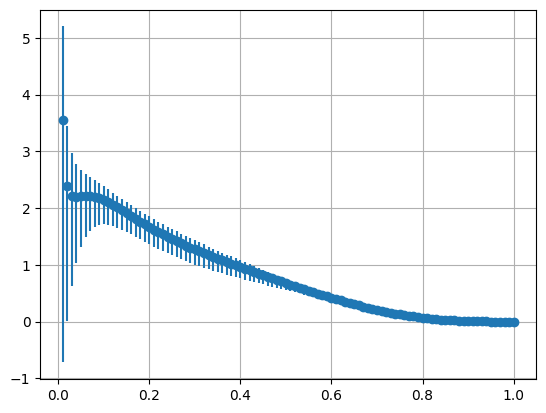

In [15]:
plot_uv_minus_dv_PDF()

Time for initial sampling: 4.074822 seconds
Time for plot computation: 8.232085 seconds


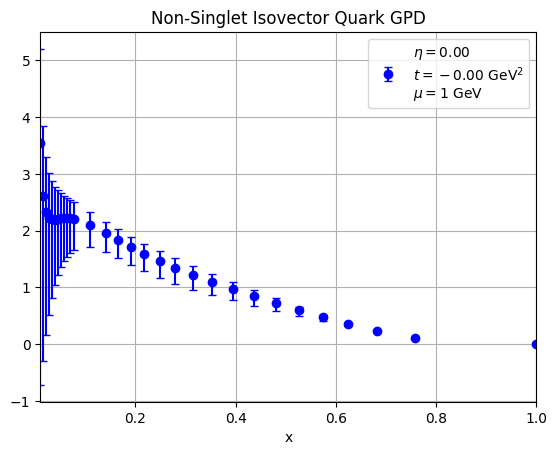

In [19]:
plot_non_singlet_quark_GPD(0,-1e-4,1,x_0=1e-2)

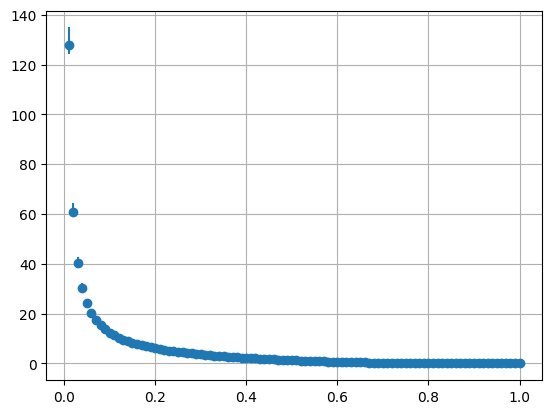

In [20]:
plot_uv_plus_dv_plus_S_PDF()

Time for plot computation: 115.425474 seconds


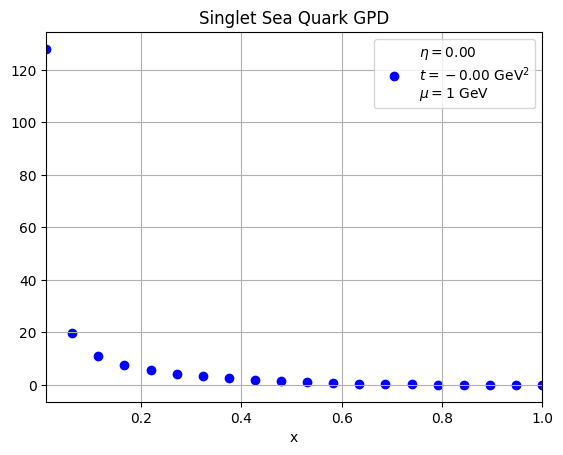

In [28]:
plot_singlet_quark_GPD(0,-1e-4,1,x_0=1e-2,sampling=False,error_bars=False,n_points=20)

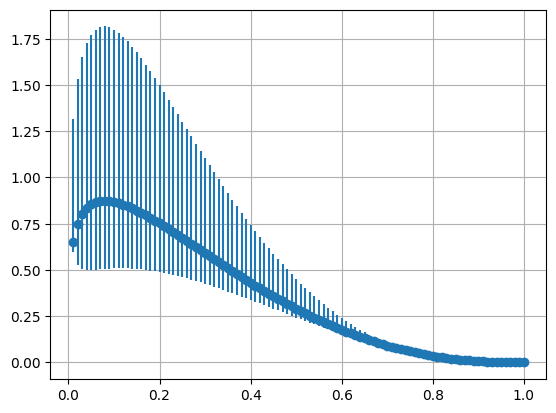

In [10]:
plot_gluon_PDF()

Time for plot computation: 152.423960 seconds


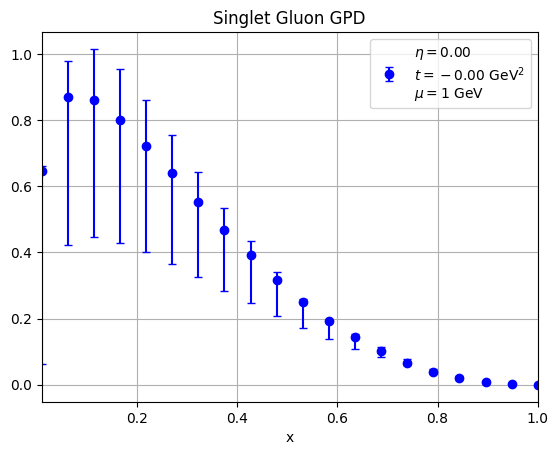

In [12]:
plot_gluon_GPD(0,-1e-4,1,x_0=1e-2,sampling=False,error_bars=True,n_points=20)

Time for initial sampling: 4.125416 seconds
Time for plot computation: 13.565579 seconds


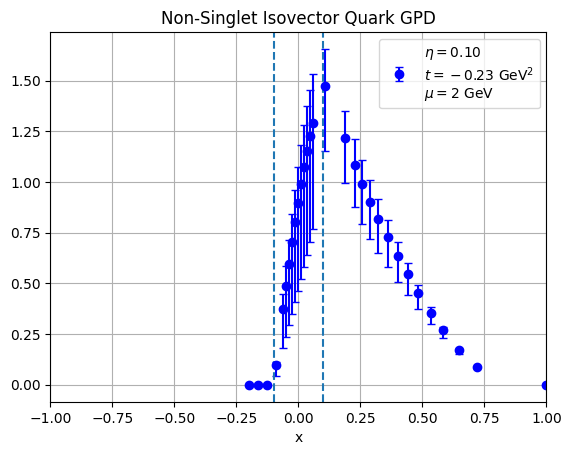

In [13]:
# Parallelized Data generation
plot_non_singlet_quark_GPD(.1,-0.23,2,3)

Time for initial sampling: 1.202597 seconds
Time for plot computation: 11.877291 seconds


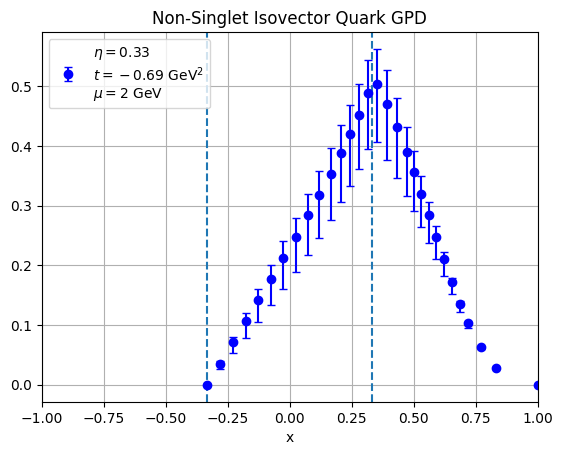

In [14]:
plot_non_singlet_quark_GPD(1/3,-0.69,2)

Time for initial sampling: 0.694547 seconds
Time for plot computation: 5.410527 seconds


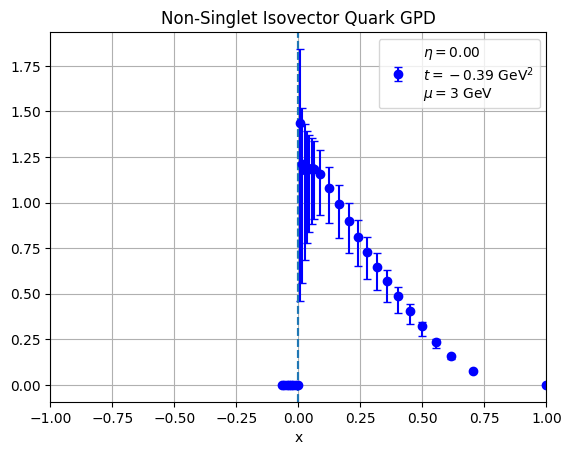

In [15]:
plot_non_singlet_quark_GPD(0,-0.39,3)

Time for initial sampling: 0.921875 seconds
Time for plot computation: 7.300370 seconds


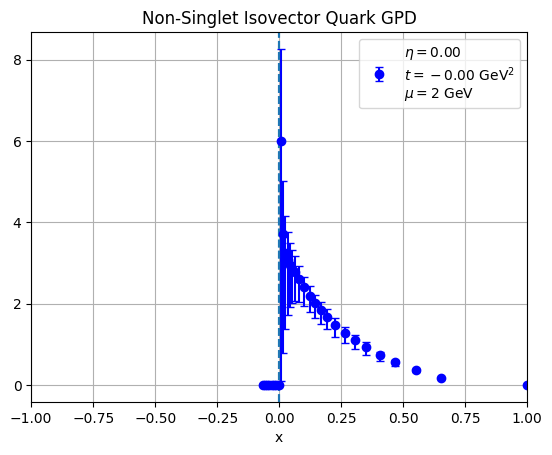

In [16]:
plot_non_singlet_quark_GPD(0,-1e-6,2)

Time for initial sampling: 16.626203 seconds
Time for plot computation: 45.317101 seconds


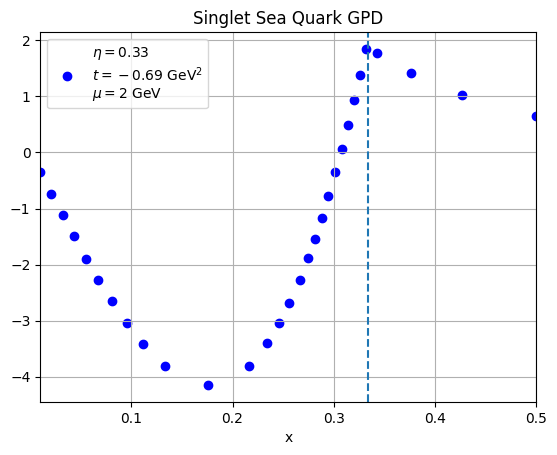

In [17]:
plot_singlet_quark_GPD(1/3,-0.69,2,sampling=True,error_bars=False,n_points=30,x_1=.5)

Time for initial sampling: 43.849976 seconds
Time for plot computation: 259.181219 seconds


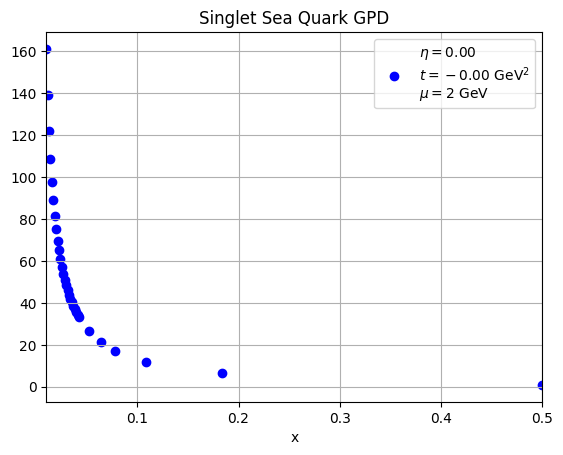

In [18]:
plot_singlet_quark_GPD(0,-1e-3,2,sampling=True,error_bars=False,n_points=30,x_1=.5)

Time for initial sampling: 37.637919 seconds
Time for plot computation: 89.408922 seconds


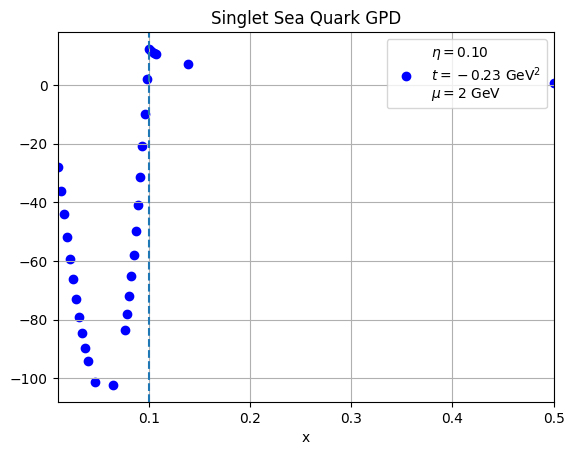

In [19]:
plot_singlet_quark_GPD(0.1,-0.23,2,sampling=True,error_bars=False,n_points=30,x_1=.5)

Time for initial sampling: 16.875003 seconds
Time for plot computation: 64.545882 seconds


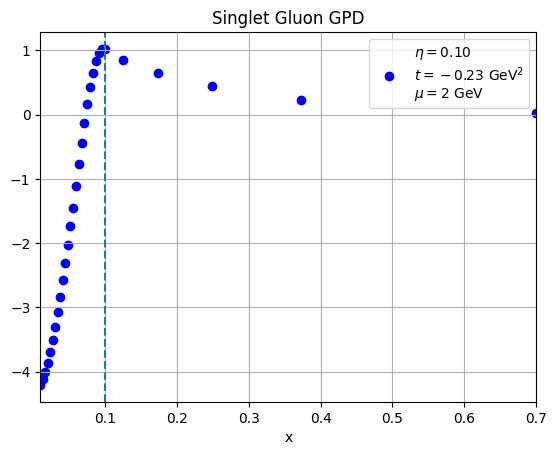

In [20]:
plot_gluon_GPD(0.1,-0.23,2,sampling=True,error_bars=False,n_points=30,x_1=.7)

Time for initial sampling: 24.517543 seconds
Time for plot computation: 54.835224 seconds


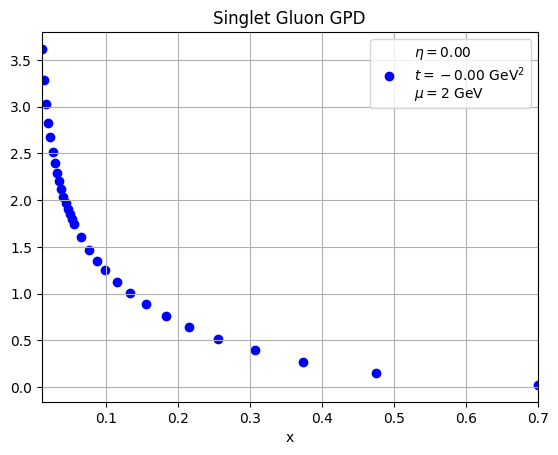

In [21]:
plot_gluon_GPD(0,-1e-3,2,sampling=True,error_bars=False,n_points=30,x_1=.7)

Time for initial sampling: 23.377475 seconds
Time for plot computation: 77.485626 seconds


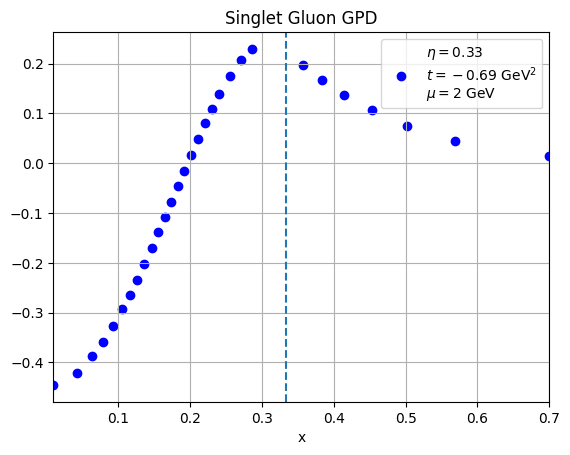

In [22]:
plot_gluon_GPD(1/3,-0.69,2,sampling=True,error_bars=False,n_points=30,x_1=.7)